In [1]:
import os
# os.environ["QAOA_FLOAT"] = "32"
from problems.integer_knapsack import IntegerKnapsack
import seaborn as sns

from fastqaoa import params
from fastqaoa import optimize_qaoa_lbfgs, Metrics, qaoa, Diagonals
from fastqaoa.optimize import optimize_linear, grid_search

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize

In [2]:
# read data

data = []

for d in sorted(os.listdir("instances")):
    if not d.startswith("n"):
        continue
    sp = d.split("_")
    n = int(sp[1])

    if "qtg" not in os.listdir(f"instances/{d}"):
        continue

    with open(os.path.join(os.path.join("instances", d), "test.in")) as f:
        dat = f.read().split("\n")
        num_vars = int(dat[0])
        capacity = int(dat[-2])
        values = [int(l.split()[1]) for l in dat[1:-2]]
        weights = [int(l.split()[2]) for l in dat[1:-2]]
        problem = IntegerKnapsack(id=n, n_qubits=n, max_capacity=capacity, weights=weights, costs=values)

    
    with open(os.path.join(os.path.join("instances", d), "qtg/p_1/powell/results.txt")) as f:
        parsed = [t(v.strip()) for t, v in zip([int, int, float, float, float], f.readlines())]
        row = dict(zip(["size", "opt", "ar_vg", "ar_qaoa", "p_succ"], parsed))
    row.update({"n": n, "problem": problem, "name": d})
    data.append(row)

df_in = pd.DataFrame(data).sort_values("n")
df_in = df_in.set_index("n")

df_in.head()

,size,opt,ar_vg,ar_qaoa,p_succ,problem,name
n,,,,,,,
5,10,576,1.000000,0.959190,0.000000,"IntegerKnapsack(id=5, n_qubits=5, max_capacity...",n_5_c_1023_g_1_f_0.3_eps_0_s_50
6,12,574,0.994774,0.968672,0.239487,"IntegerKnapsack(id=6, n_qubits=6, max_capacity...",n_6_c_1023_g_1_f_0.3_eps_0_s_50
7,80,972,0.730453,0.772737,0.544781,"IntegerKnapsack(id=7, n_qubits=7, max_capacity...",n_7_c_1023_g_2_f_0.3_eps_0_s_50
8,80,928,0.925647,0.840848,0.136611,"IntegerKnapsack(id=8, n_qubits=8, max_capacity...",n_8_c_1023_g_2_f_0.3_eps_0_s_50
9,160,910,1.000000,0.894984,0.000000,"IntegerKnapsack(id=9, n_qubits=9, max_capacity...",n_9_c_1023_g_2_f_0.3_eps_0_s_50


In [3]:
def get_scale(depth, dg, db):
    gammas = dg * np.linspace(1 / (2 * depth), 1 - 1 / (2 * depth), depth)
    betas = db * np.linspace(1 - 1 / (2 * depth), 1 / (2 * depth), depth)
    return betas, gammas

def opt_linear(dg, cost, depth, x0, method="BFGS", maxiter=100):
    def fcost(x):
        betas, gammas = get_scale(depth, *x)
        return cost.expec(qaoa(dg, betas, gammas))

    return minimize(fcost, x0, method=method, options={"maxiter": maxiter})
    

In [4]:
def for_problem(problem: IntegerKnapsack, depths: list, vg: int):
    _, constr = problem.diagonalized()
    cost = problem.masked_cost()

    vg_dat = Diagonals.from_numpy(cost.to_numpy() < -vg)
    dg = cost / np.abs(cost.min_val) * problem.n_qubits

    delta_beta = 0.5
    delta_gamma = 0.5
    result = []

    for depth in depths:
        # if depth != depths[0]:
        #     beta, gamma = params.interpolate(depth, beta, gamma)
        # res = optimize_qaoa_lbfgs(dg, cost, beta, gamma, maxiter=100)
        # beta = res.betas
        # gamma = res.gammas

        res = optimize_linear(dg, cost, depth, delta_beta, delta_gamma, maxiter=10)
        delta_beta = res.delta_beta
        delta_gamma = res.delta_gamma
        # beta, gamma = get_scale(depth, *res.x)
        # res2 = optimize_qaoa_lbfgs(dg, cost, res.betas, res.gammas)
        # beta, gamma = res2.betas, res2.gammas

        sv = qaoa(dg, res.betas, res.gammas)
        metrics = Metrics.compute(sv, cost, constr).dump()


        result.append({"n": problem.n_qubits, "depth": depth, "p_succ": vg_dat.expec(sv), **metrics})

    problem.decache()
    return pd.DataFrame(result)

In [5]:
data = []
full_data = []

for n, row in df_in.iterrows():
    print(n)
    if n > 10:
        break
    dfx = for_problem(row.problem, np.arange(1, 42, 1), row.ar_vg * row.opt)
    full_data.append(dfx)

    data.append({"name": "IF-QAOA", "n": n, "p_succ": dfx.p_succ.max(), "ar": dfx.approx_ratio.max()})
    data.append({"name": "AAM-QAOA", "n": n, "p_succ": row.p_succ, "ar": row.ar_qaoa})

5
6
7
8
9
10
11


<Axes: xlabel='n', ylabel='ar'>

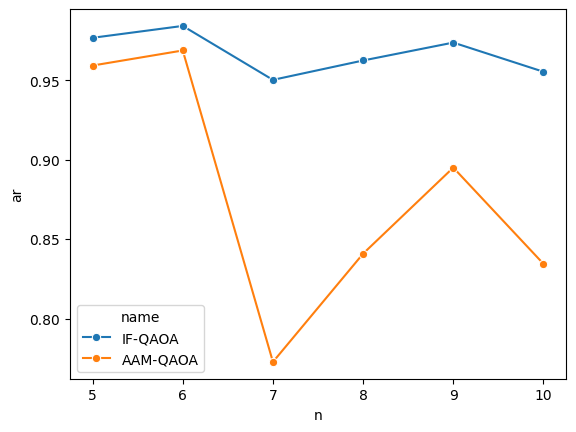

In [6]:
df = pd.DataFrame(data)

sns.lineplot(df, x="n", y="ar", hue="name", marker="o")

In [7]:
4 * np.ceil(np.log2(sum(problem.weights) * 2)) + 3  * 18 + 2

np.float64(108.0)

In [8]:
4629 / 108

42.861111111111114

(-0.0001, 1.3)

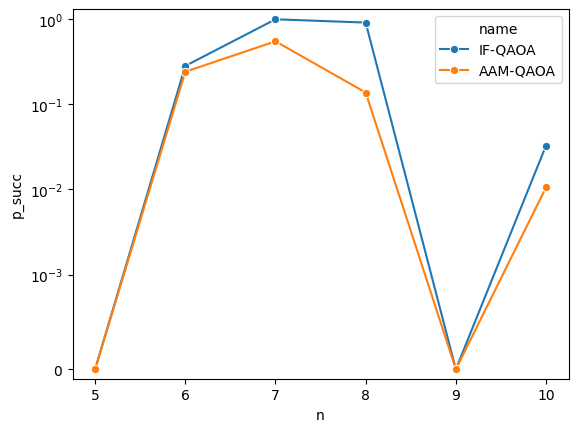

In [9]:
sns.lineplot(df, x="n", y="p_succ", hue="name", marker="o")

plt.yscale("symlog", linthresh=1e-3)
plt.ylim(-1e-4, 1.3)

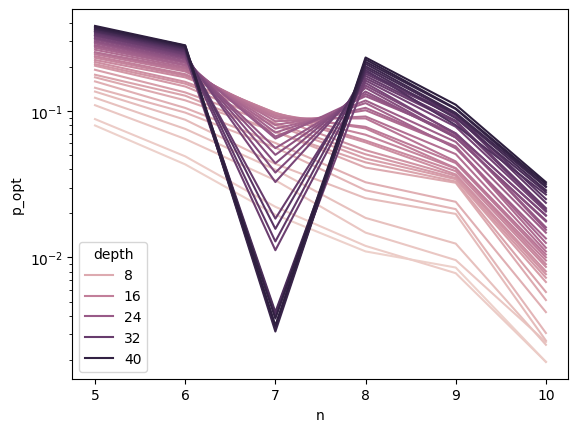

In [10]:
sns.lineplot(pd.concat(full_data), x="n", y="p_opt", hue="depth")
plt.yscale("log")

In [11]:
def ceillog2(x):
    return int(np.ceil(np.log2(x)))


def compute_k(problem):
    min_val = - sum(problem.weights) + problem.max_capacity
    max_val = problem.max_capacity
    
    return max(ceillog2(abs(min_val)), ceillog2(abs(max_val))) + 1

In [12]:
def compute_circuit_layer(problem):
    k = compute_k(problem)
    N = problem.n_qubits

    L_qft = 2 * k - 1
    L_cost = N
    L_phase = max(k, N)

    L_phase2 = min(N * (1 + 2 * ceillog2(k)), k * (1 + 2 * ceillog2(N)))
    L_cost2 = 2 * ceillog2(N) + 1

    return min(L_cost, L_cost2) + 2 * L_qft + 2 * min(L_phase, L_phase2)

In [13]:
cost_layers = {}

for n, row in df_in.iterrows():
    cost_layers[n] = compute_circuit_layer(row.problem)

In [14]:
def Lphase2(N, k):
    return min(N * (1 + 2 * ceillog2(k)), k * (1 + 2 * ceillog2(N))), max(N, k)

In [15]:
df_counts = pd.read_csv("qtg_counts.csv", names=["name", "state_prep", "phase", "mixer"])

df_counts["n"] = df_counts.name.transform(lambda x: int(x.split("_")[1]))
df_counts = df_counts.sort_values("n").set_index("n")

In [16]:
df_counts["if_cost"] = df_counts.index.map(cost_layers)

In [17]:
df_counts = df_counts.dropna().copy()

df_counts["layer_ratio"] = (df_counts.mixer + 1) / (df_counts.if_cost + 1)
df_counts["if_p"] = ((df_counts.mixer + df_counts.phase + df_counts.state_prep - 1) / (df_counts.if_cost + 1)).transform(lambda x: int(np.floor(x)))

<Axes: xlabel='n', ylabel='if_p'>

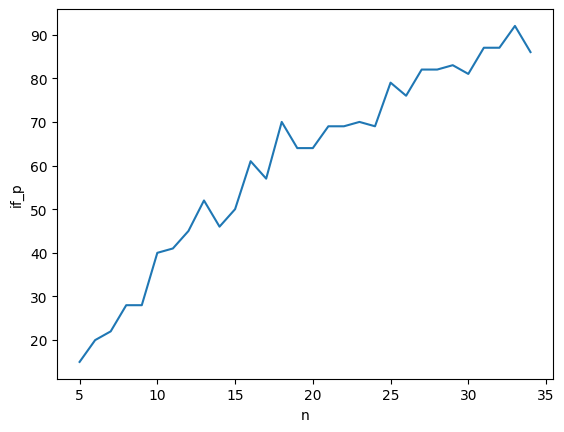

In [18]:
sns.lineplot(df_counts, x="n", y="if_p")

In [19]:
df2 = df_in.merge(df_counts, on="n")
df2

,size,opt,ar_vg,ar_qaoa,p_succ,problem,name_x,name_y,state_prep,phase,mixer,if_cost,layer_ratio,if_p
n,,,,,,,,,,,,,,
5,10,576,1.000000,0.959190,0.000000,"IntegerKnapsack(id=5, n_qubits=5, max_capacity...",n_5_c_1023_g_1_f_0.3_eps_0_s_50,n_5_c_1023_g_1_f_0.3_eps_0_s_50,383,1,789,75.0,10.394737,15
6,12,574,0.994774,0.968672,0.239487,"IntegerKnapsack(id=6, n_qubits=6, max_capacity...",n_6_c_1023_g_1_f_0.3_eps_0_s_50,n_6_c_1023_g_1_f_0.3_eps_0_s_50,516,1,1065,76.0,13.844156,20
7,80,972,0.730453,0.772737,0.544781,"IntegerKnapsack(id=7, n_qubits=7, max_capacity...",n_7_c_1023_g_2_f_0.3_eps_0_s_50,n_7_c_1023_g_2_f_0.3_eps_0_s_50,533,1,1099,71.0,15.277778,22
8,80,928,0.925647,0.840848,0.136611,"IntegerKnapsack(id=8, n_qubits=8, max_capacity...",n_8_c_1023_g_2_f_0.3_eps_0_s_50,n_8_c_1023_g_2_f_0.3_eps_0_s_50,739,1,1511,77.0,19.384615,28
9,160,910,1.000000,0.894984,0.000000,"IntegerKnapsack(id=9, n_qubits=9, max_capacity...",n_9_c_1023_g_2_f_0.3_eps_0_s_50,n_9_c_1023_g_2_f_0.3_eps_0_s_50,736,1,1505,79.0,18.825000,28
10,499,1040,0.998077,0.834432,0.010532,"IntegerKnapsack(id=10, n_qubits=10, max_capaci...",n_10_c_1023_g_3_f_0.3_eps_0_s_50,n_10_c_1023_g_3_f_0.3_eps_0_s_50,1064,1,2171,79.0,27.150000,40
11,1098,1125,0.896889,0.757678,0.145883,"IntegerKnapsack(id=11, n_qubits=11, max_capaci...",n_11_c_1023_g_3_f_0.3_eps_0_s_50,n_11_c_1023_g_3_f_0.3_eps_0_s_50,1011,1,2065,73.0,27.918919,41
12,875,1112,0.992806,0.884010,0.007512,"IntegerKnapsack(id=12, n_qubits=12, max_capaci...",n_12_c_1023_g_3_f_0.3_eps_0_s_50,n_12_c_1023_g_3_f_0.3_eps_0_s_50,1187,1,2417,79.0,30.225000,45
13,1484,1052,1.000000,0.887809,0.000000,"IntegerKnapsack(id=13, n_qubits=13, max_capaci...",n_13_c_1023_g_3_f_0.3_eps_0_s_50,n_13_c_1023_g_3_f_0.3_eps_0_s_50,1433,1,2909,81.0,35.487805,52


In [20]:
def prepare(problem, vg):
    _, constr = problem.diagonalized()
    cost = problem.masked_cost()

    vg_dat = Diagonals.from_numpy(cost.to_numpy() < -vg)
    dg = cost / np.abs(cost.min_val) * problem.n_qubits
    return dg, cost, constr, vg_dat

In [21]:
result = []
result_down = []

start_beta = 0.4
start_gamma = 0.2

for n, row in df2.iterrows():
    if n > 20:
        break
    print(f"========== {n} =========================")
    dg, cost, constr, vg_dat = prepare(row.problem, row.ar_vg * row.opt)
    res = optimize_linear(dg, cost, depth=row.if_p, delta_beta=start_beta, delta_gamma=start_gamma, maxiter=10)
    sv = qaoa(dg, res.betas, res.gammas)
    metrics = Metrics.compute(sv, cost, constr).dump()

    psucc = vg_dat.expec(sv)

    print(metrics["approx_ratio"], psucc)

    result.append({"n": n, "method": "linear", "db": res.delta_beta, "dg": res.delta_gamma, "depth": row.if_p, "p_succ": psucc, **metrics})

    beta_init, gamma_init = params.init_linear(row.if_p)
    beta_init *= res.delta_beta
    gamma_init *= res.delta_gamma

    res = optimize_qaoa_lbfgs(dg, cost, betas=beta_init, gammas=gamma_init, maxiter=50)
    sv = qaoa(dg, res.betas, res.gammas)
    metrics = Metrics.compute(sv, cost, constr).dump()

    psucc = vg_dat.expec(sv)

    print(metrics["approx_ratio"], psucc)
    result.append({"n": n, "method": "bfgs", "db": float("nan"), "dg": float("nan"), "depth": row.if_p, "p_succ": psucc, **metrics})


    print("-"*40)
    for i in range(1, row.if_p + 1):
        beta_init, gamma_init = params.init_linear(i)
        beta_init *= result[-2]["db"]
        gamma_init *= result[-2]["dg"]

        sv = qaoa(dg, beta_init, gamma_init)
        metrics = Metrics.compute(sv, cost, constr).dump()

        psucc = vg_dat.expec(sv)

        result_down.append({"n": n, "method": "direct", "depth": i, "p_succ": psucc, **metrics})

        print(i, metrics["approx_ratio"], psucc)

        res = optimize_linear(dg, cost, depth=i, delta_beta=result[-2]["db"], delta_gamma=result[-2]["dg"], maxiter=10)
        sv = qaoa(dg, res.betas, res.gammas)
        metrics = Metrics.compute(sv, cost, constr).dump()

        psucc = vg_dat.expec(sv)

        result_down.append({"n": n, "method": "linear", "depth": i, "p_succ": psucc, **metrics})

        print(i, metrics["approx_ratio"], psucc)

========== 5 =========================
0.9616375184716749 0.0
0.9746458933862875 0.0
----------------------------------------
1 0.5768528377374965 0.0
1 0.5827093010133992 0.0
2 0.5882803042493029 0.0
2 0.630516462728585 0.0
3 0.6778777474630227 0.0
3 0.7620685350538067 0.0
4 0.7918529361731853 0.0
4 0.8259818534222033 0.0
5 0.8493561928565975 0.0
5 0.8818867235081945 0.0
6 0.8735886305490124 0.0
6 0.9135730562673557 0.0
7 0.9004186074265458 0.0
7 0.9308049987636894 0.0
8 0.9305367094913112 0.0
8 0.9418233871464011 0.0
9 0.9400976755766994 0.0
9 0.94953135365402 0.0
10 0.9473215965691857 0.0
10 0.9534996002248345 0.0
11 0.9535942061863205 0.0
11 0.9562963830012848 0.0
12 0.9577620560215627 0.0
12 0.9578835928121712 0.0
13 0.9592965141617555 0.0
13 0.9594148019904958 0.0
14 0.960178295051981 0.0
14 0.961285997813024 0.0
15 0.9616375184716749 0.0
15 0.9620465703897623 0.0
========== 6 =========================
0.9707820628375674 0.1986980256633494
0.9793893720563158 0.22533082638393906
-

In [27]:
df_if = pd.DataFrame(result)
df_down = pd.DataFrame(result_down)

In [28]:
df_down

,n,method,depth,p_succ,energy,approx_ratio,feas_ratio,feas_approx_ratio,p_opt,p_999,p_99,p_9,rnd_approx_ratio,min_val,rnd_val,max_val
0,5,direct,1,0.000000,-332.267235,0.576853,0.635818,0.907260,0.078455,0.078455,0.078455,0.536014,0.444800,-576.0,-137.000000,0.0
1,5,linear,1,0.000000,-335.640557,0.582709,0.630204,0.924637,0.079592,0.079592,0.079592,0.541920,0.452484,-576.0,-137.000000,0.0
2,5,direct,2,0.000000,-338.849455,0.588280,0.636496,0.924248,0.080022,0.080022,0.080022,0.547063,0.459794,-576.0,-137.000000,0.0
3,5,linear,2,0.000000,-363.177483,0.630516,0.679310,0.928172,0.087971,0.087971,0.087971,0.587706,0.515211,-576.0,-137.000000,0.0
4,5,direct,3,0.000000,-390.457583,0.677878,0.727917,0.931257,0.098845,0.098845,0.098845,0.635010,0.577352,-576.0,-137.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,20,linear,62,0.015069,-1036.322124,0.915479,0.992133,0.922738,0.000085,0.000203,0.000845,0.763749,0.894940,-1132.0,-221.303683,0.0
1402,20,direct,63,0.015857,-1037.470957,0.916494,0.992225,0.923676,0.000087,0.000204,0.000862,0.773569,0.896201,-1132.0,-221.303683,0.0
1403,20,linear,63,0.015584,-1037.498595,0.916518,0.992567,0.923381,0.000086,0.000199,0.000844,0.770281,0.896232,-1132.0,-221.303683,0.0
1404,20,direct,64,0.016455,-1038.609276,0.917499,0.992563,0.924374,0.000091,0.000199,0.000851,0.780010,0.897451,-1132.0,-221.303683,0.0


Text(0.5, 0.8, 'crossover $p = 54$ $(55)$')

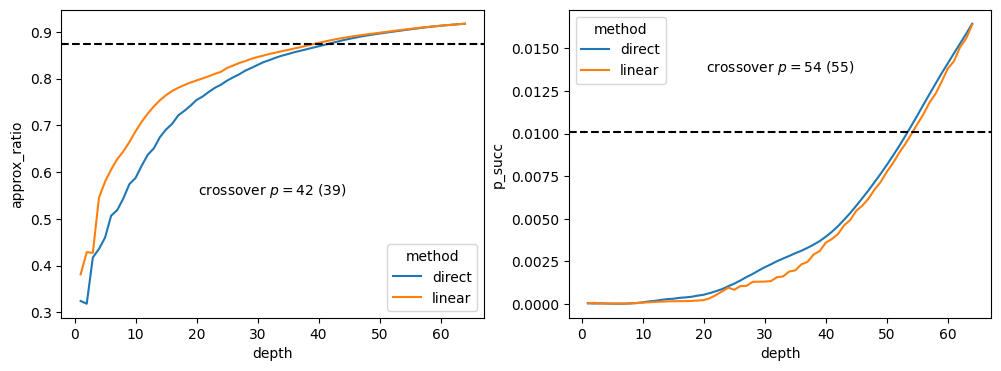

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

n = 20
in_row = df_in.query("index == @n").iloc[0]

sns.lineplot(df_down.query("n == @n"), x="depth", y="approx_ratio", hue="method", ax=ax[0])
ax[0].axhline(y=in_row.ar_qaoa, color="k", linestyle="dashed")

sns.lineplot(df_down.query("n == @n"), x="depth", y="p_succ", hue="method", ax=ax[1])
ax[1].axhline(y=in_row.p_succ, color="k", linestyle="dashed")

df_co = df_down.query("n == @n and approx_ratio > @in_row.ar_qaoa")
co = df_co.query("method == 'direct'").depth.min()
col = df_co.query("method == 'linear'").depth.min()
ax[0].text(x=0.5, y=0.4, s=f"crossover $p = {co}$ $({col})$", transform=ax[0].transAxes, ha="center")

df_co = df_down.query("n == @n and p_succ > @in_row.p_succ")
co = df_co.query("method == 'direct'").depth.min()
col = df_co.query("method == 'linear'").depth.min()
ax[1].text(x=0.5, y=0.8, s=f"crossover $p = {co}$ $({col})$", transform=ax[1].transAxes, ha="center")

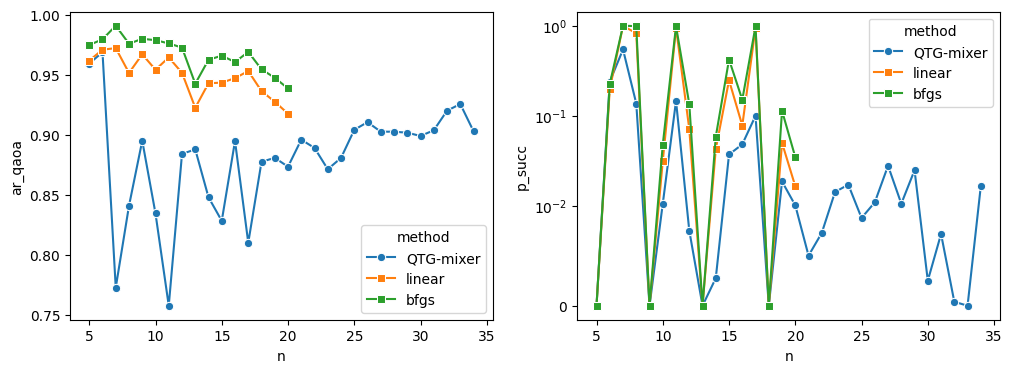

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(df_in, x="n", y="ar_qaoa", ax=ax[0], marker="o", label="QTG-mixer")
sns.lineplot(df_if, x="n", y="approx_ratio", ax=ax[0], marker="s", hue="method", palette=sns.color_palette("tab10", 3)[1:3])

sns.lineplot(df_in, x="n", y="p_succ", ax=ax[1], label="QTG-mixer", marker="o")
sns.lineplot(df_if, x="n", y="p_succ", ax=ax[1], marker="s", hue="method", palette=sns.color_palette("tab10", 3)[1:3])
ax[1].set_yscale("symlog", linthresh=1e-2)

In [36]:
df_if.to_csv("if_results.csv", index=False)
df_down.to_csv("if_results_down.csv", index=False)

In [57]:
data_till = []

for (n, method), group in df_down.groupby(["n", "method"]):
    in_row = df_in.query("n == @n").iloc[0]
    counts_row = df_counts.query("n == @n").iloc[0]
    L = counts_row.state_prep + counts_row.phase + counts_row.mixer
    
    
    df_co = group.query("approx_ratio > @in_row.ar_qaoa")
    co = df_co.depth.min()
    Lif = 1 + (1 + counts_row.if_cost) * co
    
    data_till.append({"n": n, "kind": "ar", "method": method, "till_p": co, "Lif": Lif, "L": L, "Lratio": Lif / L})
    df_co = group.query("p_succ > @in_row.p_succ")
    co = df_co.depth.min()
    Lif = 1 + (1 + counts_row.if_cost) * co
    
    data_till.append({"n": n, "kind": "psucc", "method": method, "till_p": co, "Lif": Lif, "L": L, "Lratio": Lif / L})

df_till = pd.DataFrame(data_till)

Text(0.5, 1.0, 'p_succ')

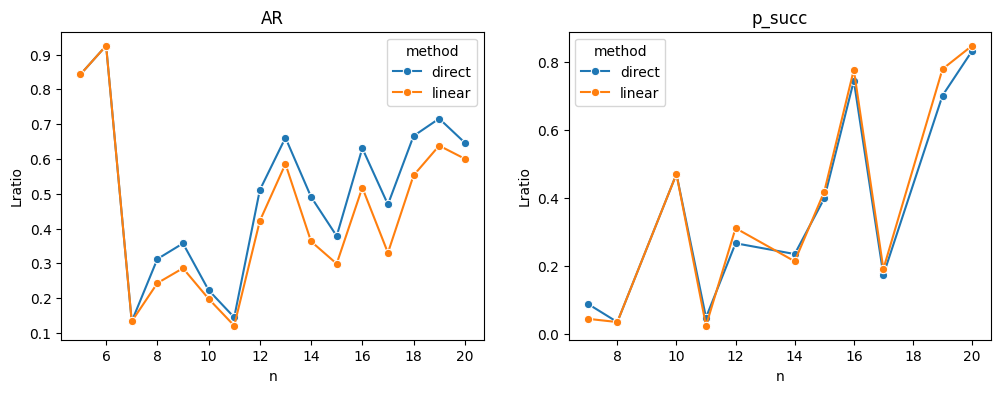

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(df_till.query("kind == 'ar'"), x="n", y="Lratio", hue="method", marker="o", ax=ax[0])
sns.lineplot(df_till.query("kind == 'psucc'"), x="n", y="Lratio", hue="method", marker="o", ax=ax[1])
ax[0].set_title("AR")
ax[1].set_title("p_succ")

In [136]:
def f(x):
    counts = df_counts.query("n == @n").iloc[0]
    rep = np.ceil(np.log(0.01) / np.log(1 - x.p_succ))
    c =  (1 + (1 * counts.if_cost) * x.depth) * rep
    return c

df_down["tts"] = df_down.groupby("n", group_keys=False)[["n", "p_succ", "depth"]].apply(f)

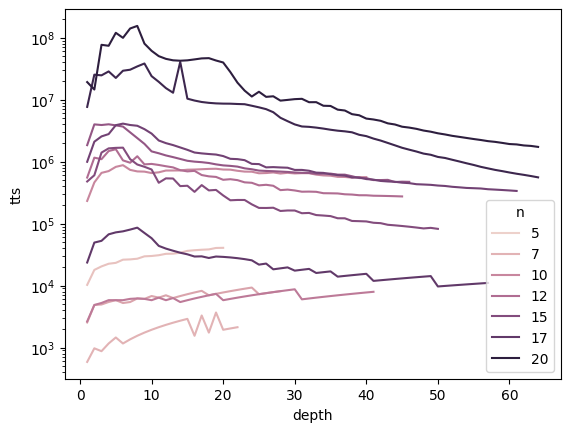

In [137]:
n = 20

dfx = df_down.query("method == 'linear'")
sns.lineplot(dfx, x="depth", y="tts", hue="n")
plt.yscale("log")